In [1]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [2]:
import os
import subprocess
import pandas as pd
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [16]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
warnings.simplefilter('ignore')

In [ ]:
directory = 'gs://msca-bdp-students-bucket/shared_data/linhcle/final_project/clean2/'
# file = '*.json'
# path = directory + file
path = directory

In [ ]:
cmd = 'hadoop fs -du -s -h ' + directory

p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, universal_newlines=True)
for line in p.stdout.readlines():
    print (line)
    
retval = p.wait()

In [ ]:
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled",True) 

In [ ]:
%%time

tweets_df_clean = spark.read.parquet(path)

### IV. Location Analysis

In [17]:
user_type = tweets_df_clean.select(col('user_screen_name').alias('retweeted_status_user_screen_name'),col('user_type').alias('retweeted_status_user_type')).drop_duplicates()

In [18]:
tweets_df_complete = tweets_df_clean.join(user_type,tweets_df_clean['retweeted_status_user_screen_name'] == user_type['retweeted_status_user_screen_name'],how='left').drop(user_type['retweeted_status_user_screen_name'])

In [19]:
tweets_df_complete = tweets_df_complete.dropDuplicates(['user_screen_name','id','text','created_at'])

In [21]:
tweets_location = tweets_df_complete[~tweets_df_complete.place_country.isNull()]

In [25]:
user_counts = tweets_location.groupBy('place_country').agg(countDistinct('user_screen_name'))

In [27]:
user_counts.orderBy('count(user_screen_name)',ascending=False).limit(20)

place_country,count(user_screen_name)
United States,98303
United Kingdom,10946
India,10125
Nigeria,4544
Canada,4293
Republic of the P...,2063
South Africa,1957
Pakistan,1820
Australia,1644
Kingdom of Saudi ...,1625


22/12/08 04:39:20 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 37 for reason Container marked as failed: container_1670471703299_0003_01_000041 on host: hub-msca-bdp-dphub-students-linhcle-sw-27lg.c.msca-bdp-students.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
22/12/08 04:39:20 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 38 for reason Container marked as failed: container_1670471703299_0003_01_000042 on host: hub-msca-bdp-dphub-students-linhcle-sw-27lg.c.msca-bdp-students.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
22/12/08 04:39:20 ERROR org.apache.spark.scheduler.cluster.YarnScheduler: Lost executor 37 on hub-msca-bdp-dphub-students-linhcle-sw-27lg.c.msca-bdp-students.internal: Container marked as failed: container_1670471703299_0003_01_000041 on host: hub-msca-bdp

#### V. Timeline Analysis

In [28]:
tweets_df_timeline = tweets_df_complete.withColumn('dow', substring('created_at', 1,3))\
    .withColumn('date', substring('created_at', 9,2))\
    .withColumn('month', substring('created_at', 5,3))\
    .withColumn('month2', substring('created_at', 5,3))\
    .withColumn('year', substring('created_at', 27,4))\
    .withColumn('hour', substring('created_at', 12,2))

In [29]:
monthDict = {"Jan":'01',"Feb":'02',"Mar":'03',"Apr":'04',"May":'05',"Jun":'06',"Jul":'07',"Aug":'08',"Sep":'09',"Oct":'10',"Nov":'11',"Dec":'12'}
tweets_df_timeline = tweets_df_timeline.replace(monthDict,subset=['month2'])
tweets_df_timeline = tweets_df_timeline.withColumn('month_date', concat_ws('-',tweets_df_timeline.month2,tweets_df_timeline.date))

In [30]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [31]:
most_freq_wd = tweets_df_timeline.groupBy('dow').agg(count('id'))

Text(0.5, 1.0, 'Number of Tweets per Day of Week')

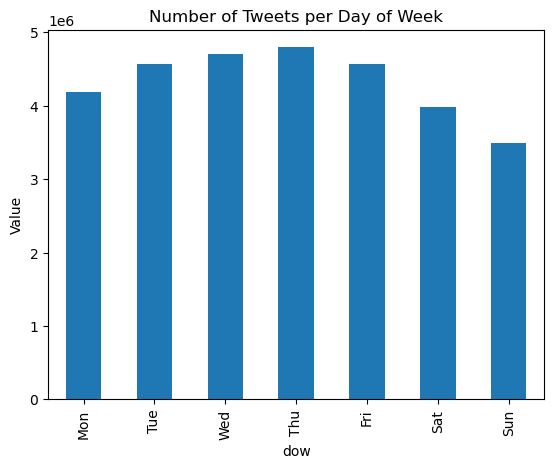

In [32]:
field = "dow"
day_order = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
most_freq_wd = most_freq_wd.toPandas()
ax = most_freq_wd.set_index(field).loc[day_order].plot(kind="bar", legend=False)
ax.set_ylabel("Value")
plt.title('Number of Tweets per Day of Week')

No handles with labels found to put in legend.                                  


Text(0.5, 1.0, 'Number of Tweets per Hour')

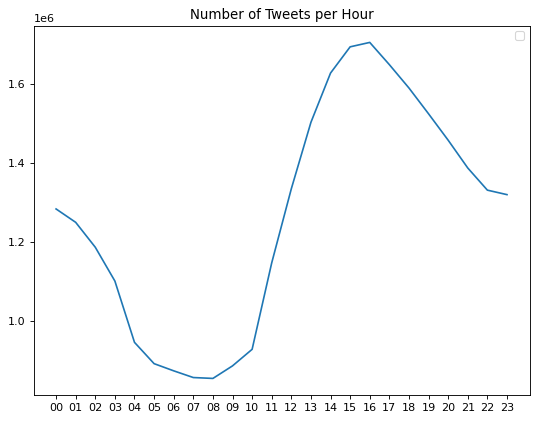

In [37]:
most_freq_hour = tweets_df_timeline.groupBy('hour').agg(count('id')).orderBy('hour',ascending=True)
most_freq_hour = most_freq_hour.toPandas()
figure(figsize=(8, 6), dpi=80)
plt.plot(most_freq_hour['hour'],most_freq_hour['count(id)'])
plt.legend()
plt.title('Number of Tweets per Hour')

Text(0.5, 1.0, 'Number of Tweets per Month')

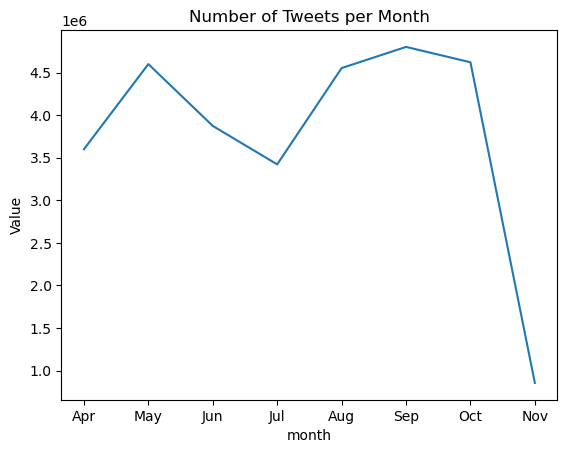

In [34]:
most_freq_month = tweets_df_timeline.groupBy('month').agg(count('id'))
field = "month"
# month_order = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
month_order = ["Apr","May","Jun","Jul","Aug","Sep","Oct","Nov"]
most_freq_month = most_freq_month.toPandas()
ax = most_freq_month.set_index(field).loc[month_order].plot(legend=False)
ax.set_ylabel("Value")
plt.title('Number of Tweets per Month')

Text(0.5, 1.0, 'Number of Tweets per Month-Date')

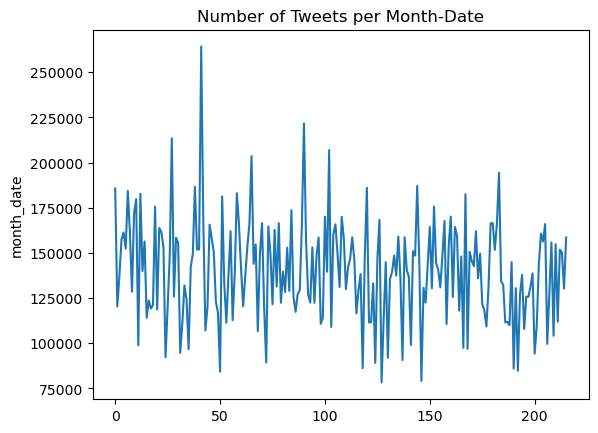

In [40]:
most_freq_monthdate = tweets_df_timeline.groupBy(['month_date']).agg(count('id'))
most_freq_monthdate
most_freq_monthdate = most_freq_monthdate.toPandas()
ax = most_freq_monthdate.plot(legend=False)
ax.set_ylabel("month_date")
plt.title('Number of Tweets per Month-Date')

Text(0.5, 1.0, 'Number of Tweets per Month-Date')

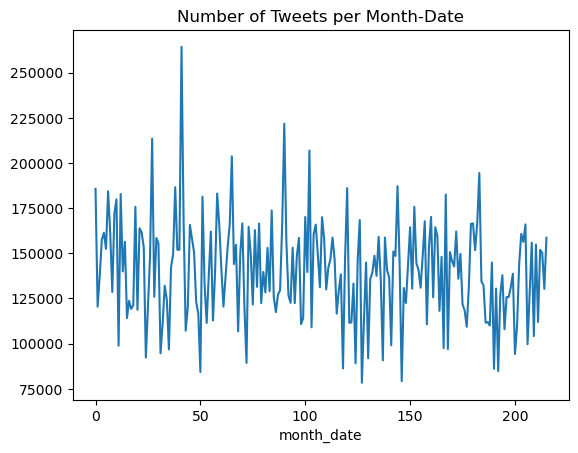

In [41]:
ax = most_freq_monthdate.plot(legend=False)
ax.set_xlabel("month_date")
plt.title('Number of Tweets per Month-Date')